# SPT local backgrounds SNR plots
Author: Benjamin Floyd

This notebook computes and displays the SNRs between the line-of-sight IR-bright AGN and the local backgrounds for each of the clusters.

In [1]:
import json
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import QTable, join, vstack
from astropy.wcs import WCS

In [2]:
def calculate_area(mask_files: list) -> u.Quantity:
    # Read in each mask file and calculate the allowable area
    areas = []
    for mask_file in mask_files:
        mask_img, mask_hdr = fits.getdata(mask_file, header=True)
        mask_wcs = WCS(mask_hdr)

        # Get the area of a pixel in angular units
        pixel_area = mask_wcs.proj_plane_pixel_area()

        # Find the total area of the image by adding all pixels and multiplying by the pixel area
        mask_area = np.count_nonzero(mask_img) * pixel_area
        areas.append(mask_area)

    # Compute total area in sample
    return u.Quantity(areas).sum()

In [29]:
# Read in the AGN catalog
sptcl_iragn = QTable.read('Data_Repository/Project_Data/SPT-IRAGN/Output/SPTcl_IRAGN_no-stars.fits')

# Also read in the local background surface density file
with open('Data_Repository/Project_Data/SPT-IRAGN/local_backgrounds/SPTcl-local_bkg_frac_err_pivot_max_annulus_out09d.json') as f:
    local_bkgs = json.load(f)
# Recast as a table
local_bkgs = QTable(rows=[[cluster_name, surf_den] for cluster_name, surf_den in local_bkgs.items()], names=['SPT_ID', 'local_bkg_surf_den'], units=[None, u.deg**-2])

In [30]:
# Ensure only AGN are in the catalog
sptcl_iragn = sptcl_iragn[sptcl_iragn['SELECTION_MEMBERSHIP'] >= 0.5]

# Group the catalog by cluster
sptcl_iragn_grp = sptcl_iragn.group_by('SPT_ID')

# Gather cluster information
cluster_info = vstack([QTable(cluster['SPT_ID', 'SZ_RA', 'SZ_DEC', 'REDSHIFT', 'M500', 'R500'][0]) for cluster in sptcl_iragn_grp.groups])

In [31]:
# Compute the line-of-sight surface densities
los_surf_dens = []
for cluster in sptcl_iragn_grp.groups:
    cluster_id = cluster['SPT_ID'][0]
    mask_name = cluster['MASK_NAME'][0]

    # Compute the number of AGN in the line-of-sight
    los_no_agn = cluster['COMPLETENESS_CORRECTION'].sum()

    # Compute the area of the line-of-sight field
    los_area = calculate_area([mask_name])

    los_surf_den = los_no_agn / los_area
    los_surf_dens.append([cluster_id, los_no_agn, los_area, los_surf_den])
los_surf_dens = QTable(rows=los_surf_dens, names=['SPT_ID', 'los_no_agn', 'los_area', 'los_surf_den'], units=[None, None, u.deg**2, u.deg**-2])

In [32]:
# Merge the two tables
sptcl_surf_dens = join(los_surf_dens, local_bkgs, keys='SPT_ID')

# Add the cluster information
sptcl_surf_dens = join(sptcl_surf_dens, cluster_info, keys='SPT_ID')

# Compute the "cluster" surface densities
sptcl_surf_dens['cluster_surf_den'] = sptcl_surf_dens['los_surf_den'] - sptcl_surf_dens['local_bkg_surf_den']

In [33]:
sptcl_surf_dens['cluster_surf_den'].mean().to(u.arcmin**-2), sptcl_surf_dens['cluster_surf_den'].std().to(u.arcmin**-2)

(<Quantity 0.03112216 1 / arcmin2>, <Quantity 0.32116616 1 / arcmin2>)

[Text(0.5, 0, 'Cluster Redshift'),
 Text(0, 0.5, '$\\Sigma_{\\rm AGN, LoS} - \\Sigma_{\\rm AGN, bkg}$ [arcmin$^{-2}$]')]

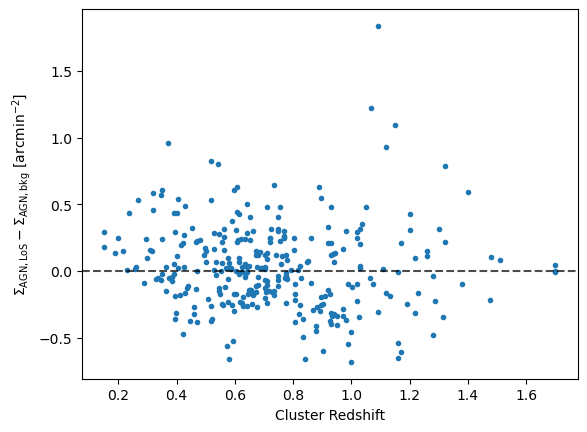

In [34]:
fig, ax = plt.subplots()
cb = ax.scatter(sptcl_surf_dens['REDSHIFT'], sptcl_surf_dens['cluster_surf_den'].to_value(u.arcmin**-2), marker='.')
ax.axhline(0., ls='--', c='k', alpha=0.7)
ax.set(xlabel='Cluster Redshift', ylabel=r'$\Sigma_{\rm AGN, LoS} - \Sigma_{\rm AGN, bkg}$ [arcmin$^{-2}$]')
# fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/cluster-bkg_snr/cluster_agn_surf_den-z.pdf')

[Text(0.5, 0, '$M_{500}$ [$10^{14} M_\\odot$]'),
 Text(0, 0.5, '$\\Sigma_{\\rm AGN, LoS} - \\Sigma_{\\rm AGN, bkg}$ [arcmin$^{-2}$]')]

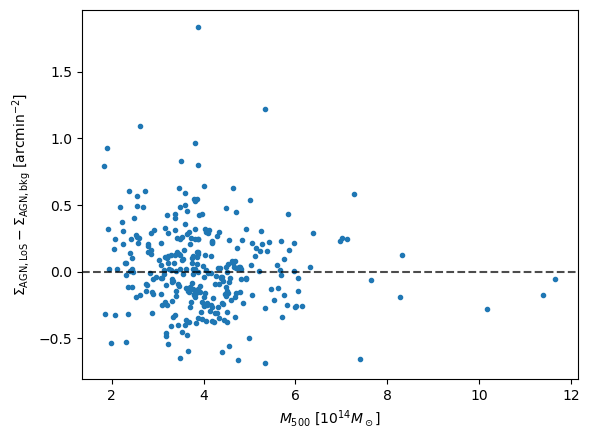

In [36]:
fig, ax = plt.subplots()
cb = ax.scatter(sptcl_surf_dens['M500']/1e14, sptcl_surf_dens['cluster_surf_den'].to_value(u.arcmin**-2), marker='.')
# plt.colorbar(cb, label=r'$M_{500}$ [$10^{14} M_\odot$]')
ax.axhline(0., ls='--', c='k', alpha=0.7)
ax.set(xlabel=r'$M_{500}$ [$10^{14} M_\odot$]', ylabel=r'$\Sigma_{\rm AGN, LoS} - \Sigma_{\rm AGN, bkg}$ [arcmin$^{-2}$]')
# fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/cluster-bkg_snr/cluster_agn_surf_den-m500.pdf')

In [37]:
cluster_excess = sptcl_surf_dens['los_no_agn'] - (sptcl_surf_dens['local_bkg_surf_den'] * sptcl_surf_dens['los_area'])
field_err = np.sqrt(sptcl_surf_dens['local_bkg_surf_den'] * sptcl_surf_dens['los_area'])
sptcl_surf_dens['snr'] = np.abs(cluster_excess) / field_err

[Text(0.5, 0, 'Cluster Redshift')]

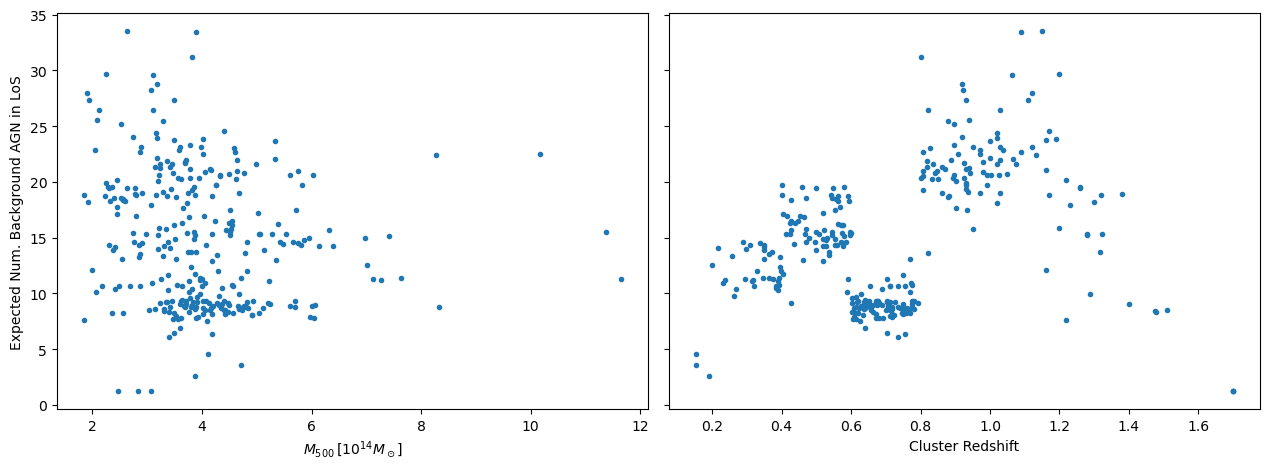

In [38]:
fig, (ax, bx) = plt.subplots(ncols=2, figsize=(6.4*2, 4.8), sharey='row', tight_layout=True)
ax.scatter(sptcl_surf_dens['M500']/1e14, sptcl_surf_dens['local_bkg_surf_den'] * sptcl_surf_dens['los_area'], marker='.')
ax.set(xlabel=r'$M_{500}\/ [10^{14} M_\odot]$', ylabel='Expected Num. Background AGN in LoS')

bx.scatter(sptcl_surf_dens['REDSHIFT'], sptcl_surf_dens['local_bkg_surf_den'] * sptcl_surf_dens['los_area'], marker='.')
bx.set(xlabel='Cluster Redshift')

[Text(0.5, 0, 'Cluster Redshift')]

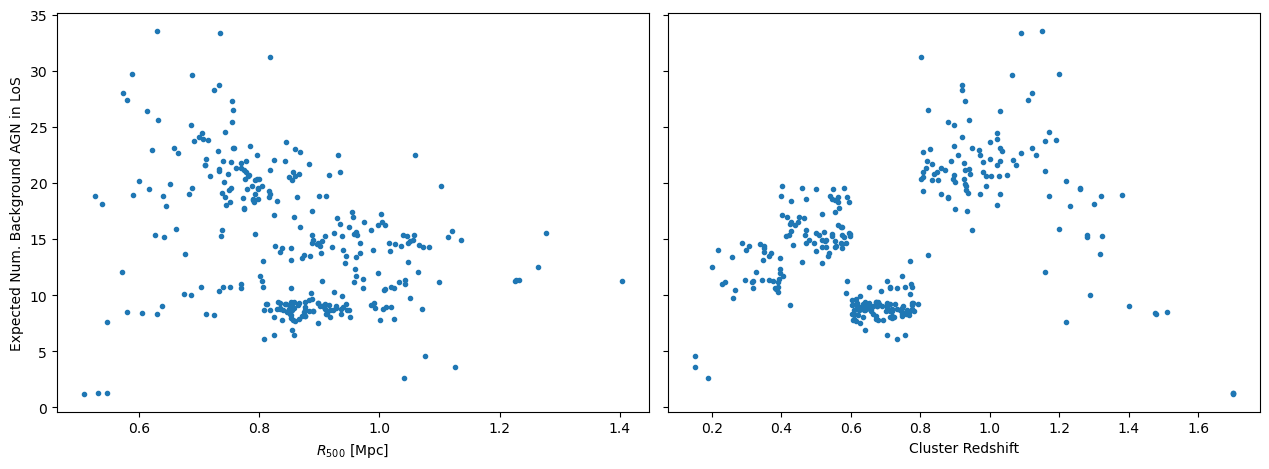

In [39]:
fig, (ax, bx) = plt.subplots(ncols=2, figsize=(6.4*2, 4.8), sharey='row', tight_layout=True)
ax.scatter(sptcl_surf_dens['R500'], sptcl_surf_dens['local_bkg_surf_den'] * sptcl_surf_dens['los_area'], marker='.')
ax.set(xlabel=r'$R_{500}$ [Mpc]', ylabel='Expected Num. Background AGN in LoS')

bx.scatter(sptcl_surf_dens['REDSHIFT'], sptcl_surf_dens['local_bkg_surf_den'] * sptcl_surf_dens['los_area'], marker='.')
bx.set(xlabel='Cluster Redshift')

In [40]:
sptcl_surf_dens['local_bkg_surf_den']

<Quantity [1453.6417641 , 1529.10845201, 3526.28928728, 3803.58471432,
           2761.29666023, 4058.32238695, 2672.98074951, 2650.90177183,
           1612.24287828, 3918.09920809, 1588.02896772, 1501.26245487,
           3765.84937056, 3302.9387044 , 4297.90134718, 3709.89103761,
           3575.50212757, 1487.13767371, 3511.14687488, 3927.64295409,
           3831.97673757, 1534.3547993 , 3722.19424768, 2566.85921162,
           2821.12356749, 3748.69346938, 1598.92522747, 1569.46496962,
           1642.10670131, 4168.25905268, 3497.89726403, 3614.30455934,
           1402.38898674, 1569.06140444, 2777.67783722, 1644.93165754,
           3654.99979267, 1565.83288303, 2746.33993341, 2703.60642822,
           3563.1989175 , 2806.16684068, 2655.17512235, 1611.43574793,
           1660.26713423, 1699.4129563 , 2859.58372216, 1570.27209997,
           2865.99374794, 1634.43896296, 1588.43253289, 2804.7423905 ,
           2811.15241628, 1688.11313137, 2816.85021697, 1590.85392395,
      

[Text(0.5, 0, 'Cluster Redshift'), Text(0, 0.5, 'Cluster SNR')]

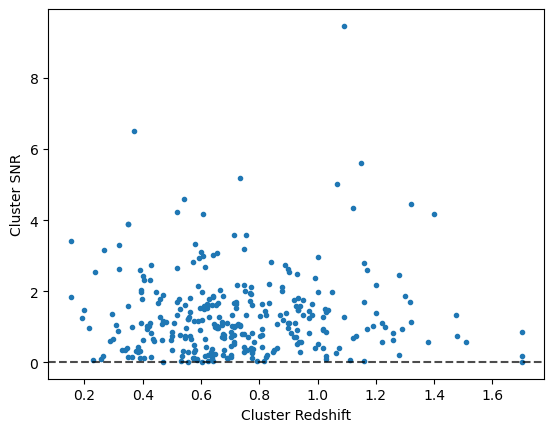

In [41]:
fig, ax = plt.subplots()
ax.scatter(sptcl_surf_dens['REDSHIFT'], sptcl_surf_dens['snr'], marker='.')
ax.axhline(0., ls='--', c='k', alpha=0.7)
ax.set(xlabel='Cluster Redshift', ylabel='Cluster SNR')
# fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/cluster-bkg_snr/cluster_agn_snr.pdf')

[Text(0.5, 0, 'Cluster SNR')]

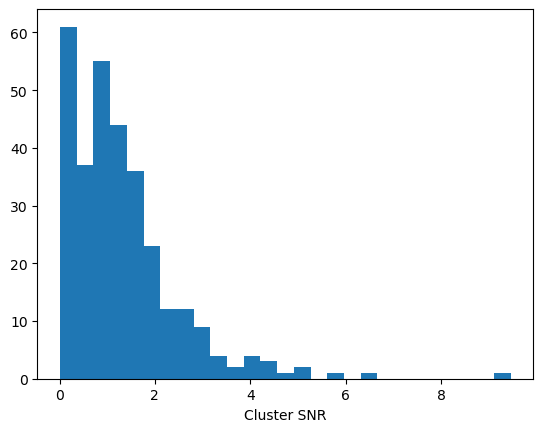

In [42]:
fig, ax = plt.subplots()
ax.hist(sptcl_surf_dens['snr'], bins='auto')
ax.set(xlabel='Cluster SNR')

In [43]:
sptcl_surf_dens['snr'].mean()

<Quantity 1.31752596>

In [44]:
sptcl_surf_dens['local_bkg_surf_den'].mean().to(u.arcmin**-2), sptcl_surf_dens['los_surf_den'].mean().to(u.arcmin**-2)

(<Quantity 0.70719625 1 / arcmin2>, <Quantity 0.73831841 1 / arcmin2>)

[Text(0.5, 0, '$\\Sigma_{\\rm AGN, cl}$ [arcmin$^{-2}$]'),
 Text(0.5, 1.0, 'Cluster Excess in LoS')]

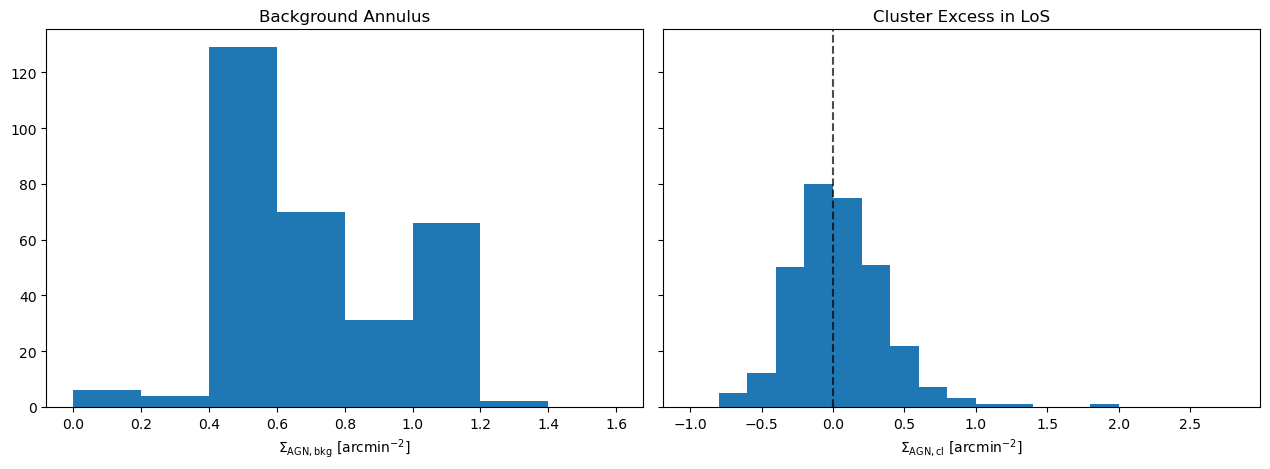

In [45]:
surf_den_bins_bkg = np.arange(0., 1.8, 0.2)
surf_den_bins_cl = np.arange(-1., 3., 0.2)
fig, (ax, bx) = plt.subplots(ncols=2, sharey='row', figsize=(6.4*2, 4.8), tight_layout=True)
ax.hist(sptcl_surf_dens['local_bkg_surf_den'].to_value(u.arcmin**-2), bins=surf_den_bins_bkg)
ax.set(xlabel=r'$\Sigma_{\rm AGN, bkg}$ [arcmin$^{-2}$]', title='Background Annulus')

bx.hist(sptcl_surf_dens['cluster_surf_den'].to_value(u.arcmin**-2), bins=surf_den_bins_cl)
bx.axvline(0., ls='--', c='k', alpha=0.7)
bx.set(xlabel=r'$\Sigma_{\rm AGN, cl}$ [arcmin$^{-2}$]', title='Cluster Excess in LoS')

[Text(0.5, 0, 'Number of AGN within LoS footprint')]

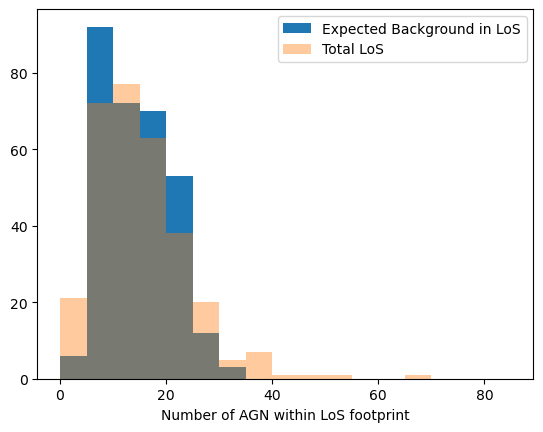

In [46]:
agn_numb_bins = np.arange(0., 90., 5.)
fig, ax = plt.subplots()
ax.hist(sptcl_surf_dens['local_bkg_surf_den'] * sptcl_surf_dens['los_area'], bins=agn_numb_bins, label='Expected Background in LoS')
ax.hist(sptcl_surf_dens['los_no_agn'], bins=agn_numb_bins, alpha=0.4, label='Total LoS')
ax.legend()
ax.set(xlabel='Number of AGN within LoS footprint')

[Text(0.5, 0, '$\\Sigma_{\\rm AGN}$ [arcmin$^{-2}$]')]

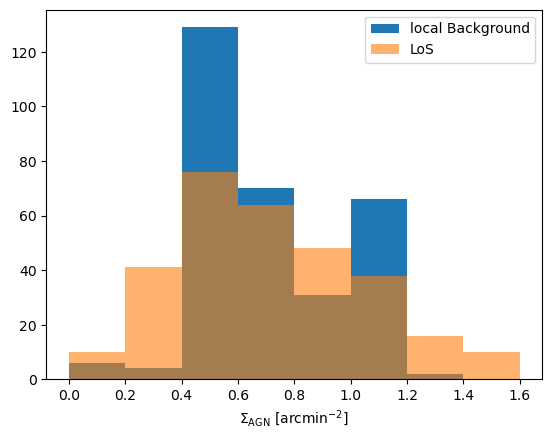

In [49]:
fig, ax = plt.subplots()
ax.hist(sptcl_surf_dens['local_bkg_surf_den'].to_value(u.arcmin**-2), bins=np.arange(0., 1.8, 0.2), label='local Background')
ax.hist(sptcl_surf_dens['los_surf_den'].to_value(u.arcmin**-2), bins=np.arange(0., 1.8, 0.2), label='LoS', alpha=0.6)
ax.legend()
ax.set(xlabel=r'$\Sigma_{\rm AGN}$ [arcmin$^{-2}$]')

[Text(0.5, 0, 'Area [arcmin$^2$]')]

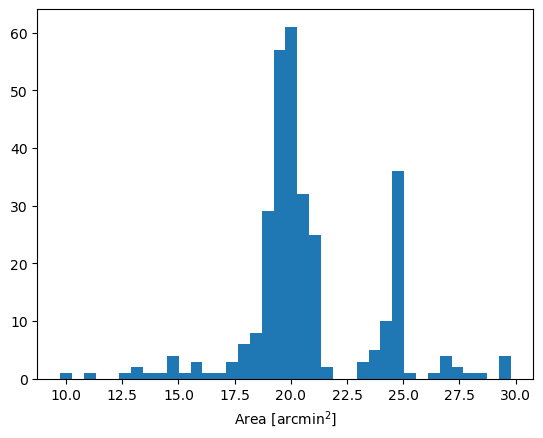

In [51]:
fig, ax = plt.subplots()
ax.hist(sptcl_surf_dens['los_area'].to_value(u.arcmin**2), bins='auto')
ax.set(xlabel='Area [arcmin$^2$]')

In [55]:
sptcl_surf_dens['SPT_ID'][sptcl_surf_dens['los_area'].argmax()]

'SPT-CLJ2218-5532'

In [63]:
spt2218_mask_name = sptcl_iragn['MASK_NAME'][sptcl_iragn['SPT_ID'] == sptcl_surf_dens['SPT_ID'][sptcl_surf_dens['los_area'].argmax()]][0]
spt2218_mask, spt2218_hdr = fits.getdata(spt2218_mask_name, header=True)
spt2218_wcs = WCS(spt2218_hdr)

num_pixels = np.count_nonzero(spt2218_mask)
pixel_area = spt2218_wcs.proj_plane_pixel_area().to(u.arcmin**2)
print(num_pixels, pixel_area, num_pixels*pixel_area)
spt2218_wcs

144117 0.0002067228581796008 arcmin2 29.792278152269528 arcmin2


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 334.548831 -55.549908 
CRPIX : 229.808 247.721 
CD1_1 CD1_2  : -0.000203243409938533 0.000126945391714538 
CD2_1 CD2_2  : 0.000126945391714538 0.000203243409938533 
NAXIS : 500  500

In [68]:
# Read in the SSDF local background
with open('Data_Repository/Project_Data/SPT-IRAGN/local_backgrounds/SPT-SSDF_local_bkg_no_stars.json') as f:
    ssdf_bkg = json.load(f)
ssdf_bkg = QTable(rows=[[cluster_name, surf_den] for cluster_name, surf_den in ssdf_bkg.items()], names=['SPT_ID', 'ssdf_surf_den'], units=[None, u.deg**-2])
sptcl_surf_dens = join(sptcl_surf_dens, ssdf_bkg, keys='SPT_ID', join_type='left')

In [76]:
ssdf_cluster_mask = ~sptcl_surf_dens['ssdf_surf_den'].mask

[Text(0.5, 0, '$\\Sigma_{\\rm AGN}$ [arcmin$^{-2}$]')]

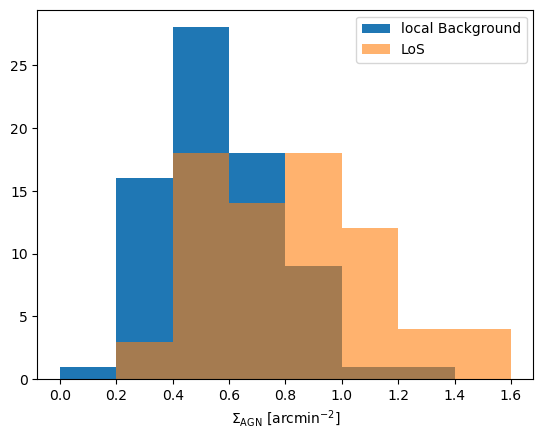

In [77]:
fig, ax = plt.subplots()
ax.hist(sptcl_surf_dens['ssdf_surf_den'][ssdf_cluster_mask].to_value(u.arcmin**-2), bins=np.arange(0., 1.8, 0.2), label='local Background')
ax.hist(sptcl_surf_dens['los_surf_den'][ssdf_cluster_mask].to_value(u.arcmin**-2), bins=np.arange(0., 1.8, 0.2), label='LoS', alpha=0.6)
ax.legend()
ax.set(xlabel=r'$\Sigma_{\rm AGN}$ [arcmin$^{-2}$]')

[Text(0.5, 0, 'Number of AGN within LoS footprint')]

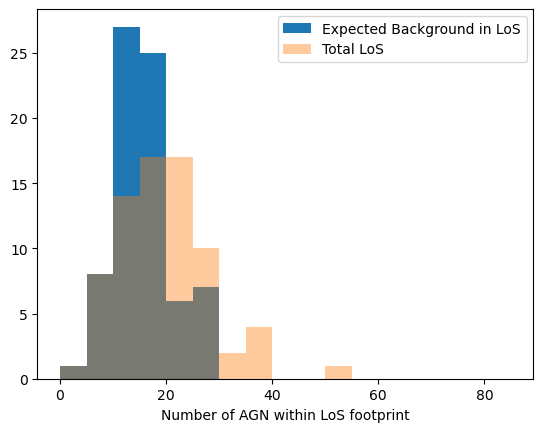

In [79]:
agn_numb_bins = np.arange(0., 90., 5.)
fig, ax = plt.subplots()
ax.hist(sptcl_surf_dens['local_bkg_surf_den'][ssdf_cluster_mask] * sptcl_surf_dens['los_area'][ssdf_cluster_mask], bins=agn_numb_bins, label='Expected Background in LoS')
ax.hist(sptcl_surf_dens['los_no_agn'][ssdf_cluster_mask], bins=agn_numb_bins, alpha=0.4, label='Total LoS')
ax.legend()
ax.set(xlabel='Number of AGN within LoS footprint')

In [82]:
np.sum(sptcl_surf_dens['local_bkg_surf_den'] * sptcl_surf_dens['los_area'])

<Quantity 4524.74253004>

In [83]:
np.sum(sptcl_surf_dens['los_no_agn'])

4804.2419759002205

In [88]:
np.sum(sptcl_surf_dens['los_no_agn'] - sptcl_surf_dens['local_bkg_surf_den'] * sptcl_surf_dens['los_area'])

<Quantity 279.49944586>

In [90]:
survey_snr = (np.sum(sptcl_surf_dens['los_no_agn'] - sptcl_surf_dens['local_bkg_surf_den'] * sptcl_surf_dens['los_area'])) / np.sqrt(np.sum(sptcl_surf_dens['local_bkg_surf_den'] * sptcl_surf_dens['los_area']))
survey_snr

<Quantity 4.15512425>

In [86]:
sptcl_surf_dens.colnames

['SPT_ID',
 'los_no_agn',
 'los_area',
 'los_surf_den',
 'local_bkg_surf_den',
 'SZ_RA',
 'SZ_DEC',
 'REDSHIFT',
 'M500',
 'R500',
 'cluster_surf_den',
 'snr',
 'ssdf_surf_den']